In [1]:
import cv2
import ast
import numpy as np
import matplotlib.pyplot as plt

from metrics.BoundingBox import BoundingBox
from metrics.BoundingBoxes import BoundingBoxes
from metrics.Evaluator import Evaluator
from metrics.utils import BBFormat, BBType

In [2]:
def getBoxesIntersect(boxA, boxB):
        if boxA[0] > boxB[2]:
            return False  # boxA is right of boxB
        if boxB[0] > boxA[2]:
            return False  # boxA is left of boxB
        if boxA[3] < boxB[1]:
            return False  # boxA is above boxB
        if boxA[1] > boxB[3]:
            return False  # boxA is below boxB
        return True

def getIntersectionArea(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # intersection area
    return (xB - xA + 1) * (yB - yA + 1)

def getUnionAreas(boxA, boxB, interArea=None):
    area_A = getArea(boxA)
    area_B = getArea(boxB)
    if interArea is None:
        interArea = getIntersectionArea(boxA, boxB)
    return float(area_A + area_B - interArea)

def getArea(box):
    return (box[2] - box[0] + 1) * (box[3] - box[1] + 1)

def get_iou(boxA, boxB):
    if getBoxesIntersect(boxA, boxB) is False:
        return 0
    interArea = getIntersectionArea(boxA, boxB)
    union = getUnionAreas(boxA, boxB, interArea=interArea)
    iou = interArea / union
    assert iou >= 0
    return iou

In [3]:
IOUThreshold = 0.5

def get_iou_info(pred_bboxes, gt_bboxes):
    # Get only detection of class c
    dects = pred_bboxes
    FP_boxes = []
    
    iou_sum = 0
    TP = 0
    gt_usablecheck = [True] * len(gt_bboxes)
    for d in range(len(dects)):
        gt = gt_bboxes
        iouMax = 0
        for j in range(len(gt)):
            iou = get_iou(dects[d], gt[j])
            if iou > iouMax:
                iouMax = iou
                jmax = j

        if iouMax >= IOUThreshold:
            if gt_usablecheck[jmax]:
                gt_usablecheck[jmax] = False
                iou_sum += iouMax
                TP += 1
            else:
                FP_boxes.append(dects[d])
        else:
            FP_boxes.append(dects[d])
        
    num = len(pred_bboxes) + len(gt_bboxes) - TP
    return (iou_sum, num, TP, FP_boxes)

In [4]:
CONF_THRESHOLD = 0.3

In [5]:
def get_det_info(model_name, mixed_image_name):
    det_log = './runs/detect/'+model_name+'/labels/'+mixed_image_name+'.txt'
    with open(det_log, 'r') as f:
        lines = f.readlines()
    boxes, confs, classes = ([], [], [])
    for line in lines:
        r = line.rsplit()
        r = [float(e) for e in r]
        # cx cy w h to ltrb
        p = r[1:5]
        p = [p[0]-p[2]/2, p[1]-p[3]/2, p[0]+p[2]/2, p[1]+p[3]/2]
        p = [int(e * 800) for e in p]
        if r[5] > CONF_THRESHOLD:
            boxes.append(p)
            confs.append(r[5])
            classes.append(int(r[0]))
    return (boxes, confs, classes)

In [6]:
def get_gt_info(mixed_image_name):
    gt_log = '../coco_mixed_yolov5/size50to150/val/labels/'+mixed_image_name+'.txt'
    with open(gt_log, 'r') as f:
        gts = f.readlines()
    gt_bboxes = []
    for i in range(len(gts)):
        line = gts[i]
        r = line.rsplit()
        r = [float(e) for e in r]
        p = r[1:5]
        p = [p[0]-p[2]/2, p[1]-p[3]/2, p[0]+p[2]/2, p[1]+p[3]/2]
        p = [int(e * 800) for e in p]
        gt_bboxes.append(p)
    return gt_bboxes

In [17]:
mixed_image_names = ['mix000000', 'mix000001', 'mix000002', 'mix000003', 'mix000004']
# model_names = ['v5l6_fp16_tflite', 'v5l6_int8_tflite', 'yolov5l6_fp16_tflite', 'exp2', 'yolov5l6-int8-int-data']
model_names = ['yolov5l6_fp16_tflite', 'yolov5l6-int8-int-data']

In [8]:
det_dict = {}
gt_dict = {}
pred_dict = {}

for mixed_image_name in mixed_image_names:
    for model_name in model_names:
        det_key = model_name + '_' + mixed_image_name
        det_dict[det_key] = get_det_info(model_name, mixed_image_name)
    gt_dict[mixed_image_name] = get_gt_info(mixed_image_name)

for mixed_image_name in mixed_image_names:
    for model_name in model_names:
        pred_bboxes = []
        key = model_name + '_' + mixed_image_name
        boxes, confs, classes = det_dict[key]
        for b, conf, c in zip(boxes, confs, classes):
            if int(c) == 0:
                # c1 c2 c3
                b += [conf]
                pred_bboxes.append(b)
        pred_dict[key] = pred_bboxes

In [9]:
def format_bboxes(key, dbs, cnfs, bbtype):
    boundingBoxes = BoundingBoxes()
    for i in range(len(dbs)):
        cnf = cnfs[i] if cnfs is not None else 1
        boundingBoxes.addBoundingBox(BoundingBox(
            key, 0,
            dbs[i][0],
            dbs[i][1],
            dbs[i][2],
            dbs[i][3],
            bbType=bbtype,
            classConfidence=cnf,
            format=BBFormat.XYX2Y2
        ))
    return boundingBoxes

In [10]:
def get_formatted_det_bboxes(model_name, mixed_image_name):
    boxes, confs, classes = det_dict[model_name+'_'+mixed_image_name]
    dbs = []
    cnfs = []
    for i in range(len(classes)):
        if classes[i] == 0:
            dbs.append(boxes[i])
            cnfs.append(confs[i])
    return format_bboxes(model_name+'_'+mixed_image_name, dbs, cnfs, BBType.Detected)

In [11]:
def get_formatted_gt_bboxes(model_name, mixed_image_name):
    dbs = gt_dict[mixed_image_name]
    return format_bboxes(model_name+'_'+mixed_image_name, dbs, None, BBType.GroundTruth)

In [12]:
def get_info(model_name, mixed_image_name, conf_threshold=0.3):
    pred_bboxes = pred_dict[model_name+'_'+mixed_image_name]
    pred_bboxes = [pb for pb in pred_bboxes if pb[4] >= conf_threshold]
    gt_bboxes = gt_dict[mixed_image_name]
    iou_sum, num, TP, FP_boxes = get_iou_info(pred_bboxes, gt_bboxes)
    return (iou_sum, num, TP, len(gt_bboxes), pred_bboxes, FP_boxes)

In [13]:
def get_miou(model_name, mixed_image_name, conf_threshold=0):
    iou_sum, num, TP, gt_len, pred_bboxes, fp_boxes = get_info(model_name, mixed_image_name, conf_threshold)
    return iou_sum/num

In [14]:
def visualize_conf_distribution(tp, fp):
    tp_confs = np.array(tp)[:,4]
    fp_confs = np.array(fp)[:,4]
    x1 = np.arange(0, len(tp_confs))
    x2 = np.arange(0, len(fp_confs))
    plt.hist(tp_confs, bins=30, alpha=0.85, label='tp_conf')
    plt.hist(fp_confs, bins=30, alpha=0.85, label='fp_conf')
    plt.legend()
    plt.show()

# Check and get the best confidence threshold (TBD)

In [18]:
# model_names = ['ckpt_0101']
# mixed_image_names = ['mix000000']
for model_name in model_names:
    model_miou_sum = 0
    for mixed_image_name in mixed_image_names:
        _, _, _, _, _, fps = get_info(model_name, mixed_image_name, 0)
        fp_confs = np.array(fps)[:,4]
        max_miou = 0
        max_conf_thres = 0
        for fp_conf in fp_confs:
            miou = get_miou(model_name, mixed_image_name, fp_conf)
            if max_miou < miou:
                max_miou = miou
                max_conf_thres = fp_conf
        print(max_miou, max_conf_thres)

0.37976070073214385 0.326095
0.5233474664980607 0.34551
0.46585488021204735 0.304386
0.2937049776649402 0.31117
0.4003673710625765 0.343474
0.37284548627758124 0.309071
0.501404445214621 0.321167
0.44201408134921266 0.342022
0.26738567042723227 0.306492
0.4202849780802402 0.312671


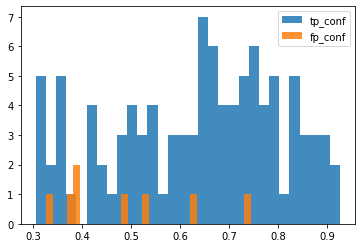

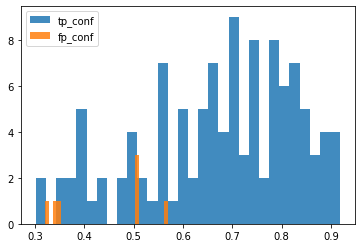

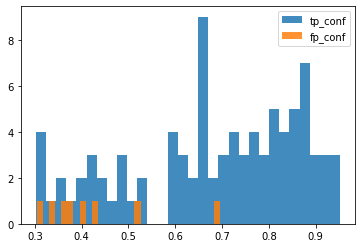

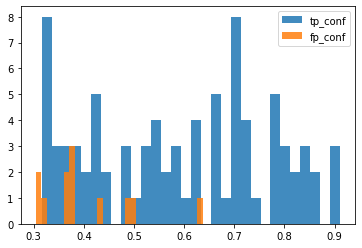

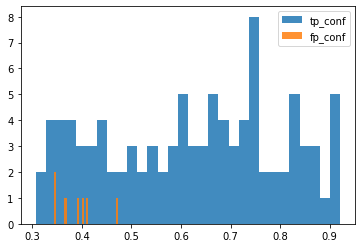

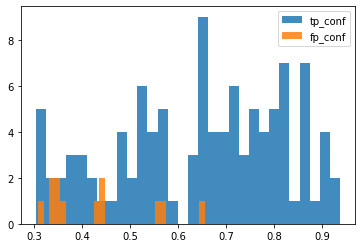

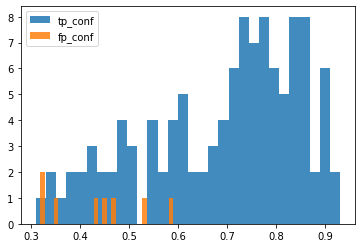

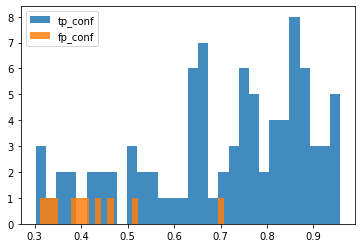

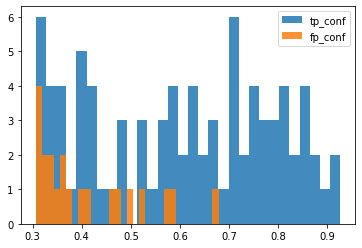

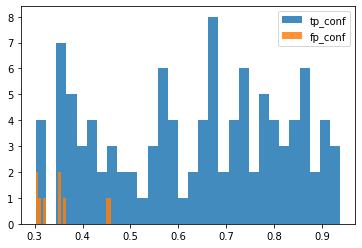

['yolov5l6_fp16_tflite', 0.4209339875200482]
['yolov5l6-int8-int-data', 0.40541228096183185]


In [19]:
# mixed_image_names = ['mix000000', 'mix000001', 'mix000002', 'mix000003', 'mix000004']
# model_names = ['ckpt_0000_1', 'ckpt_0001_1', 'ckpt_00005', 'ckpt_0101_1', 'ckpt_0101',  
#               'ckpt_0303_1', 'ckpt_0303', 'ckpt_0307', 'ckpt_0703', 'ckpt_1010', 'default']
# model_names = ['ckpt_0101']
model_miou_list = []
for model_name in model_names:
    model_miou_sum = 0
    for mixed_image_name in mixed_image_names:
        iou_sum, num, TP, gt_len, pred_bboxes, fp_boxes = get_info(model_name, mixed_image_name)
        miou = iou_sum/num
        model_miou_sum += miou
        tp = [p for p in pred_bboxes if p not in fp_boxes]
        visualize_conf_distribution(tp, fp_boxes)
    model_miou_list.append([model_name, model_miou_sum/len(mixed_image_names)])
model_miou_list = sorted(model_miou_list, key=lambda x: x[1], reverse=True)
for mm in model_miou_list:
    print(mm)

# Calculate mIoU

In [84]:
# model_miou_list = []
# for model_name in model_names:
#     model_miou_sum = 0
#     for mixed_image_name in mixed_image_names:
#         iou_sum, num, TP, gt_len, pred_bboxes, fp_boxes = get_info(model_name, mixed_image_name)
#         miou = iou_sum/num
#         model_miou_sum += miou
#     model_miou_list.append([model_name, model_miou_sum/len(mixed_image_names)])
# model_miou_list = sorted(model_miou_list, key=lambda x: x[1], reverse=True)
# for mm in model_miou_list:
#     print(mm)

# Use Pascal VOC Metrics for mIoU

In [15]:
evaluator = Evaluator()

model_miou_list = []
for model_name in model_names:
    allBoundingBoxes = BoundingBoxes()
    for mixed_image_name in mixed_image_names:
        boundingBoxes = BoundingBoxes()
        det = get_formatted_det_bboxes(model_name, mixed_image_name)
        boundingBoxes.concatBoundingBoxes(det)
        allBoundingBoxes.concatBoundingBoxes(det)
        gt = get_formatted_gt_bboxes(model_name, mixed_image_name)
        boundingBoxes.concatBoundingBoxes(gt)
        allBoundingBoxes.concatBoundingBoxes(gt)
        #print(model_name, mixed_image_name, evaluator.GetPascalVOCMetrics(boundingBoxes)[0]['AP'])
    print(model_name, evaluator.GetPascalVOCMetrics(allBoundingBoxes)[0]['AP'])

yolov5l6_fp16_tflite 0.5128658131778604
yolov5l6-int8-int-data 0.5256130948346834


# Check characteristics of fp and int quantization

In [27]:
def draw_size_miou_conf(smc):
    sizes = np.array(smc)[:,0]
    mious = np.array(smc)[:,1]
    confs = np.array(smc)[:,2]
    plt.scatter(sizes, mious, marker='o', c='red', s=2)
    plt.title('Box Size to mIoU')
    plt.xlabel('Box Size (Area)')
    plt.show()
    plt.clf()
    plt.scatter(sizes, confs, marker='o', c='green', s=2)
    plt.title('Box Size to Confidence')
    plt.xlabel('Box Size (Area)')
    plt.show()
    plt.clf()

yolov5l6_fp16_tflite 0.5128658131778604
TP conf 0.6412039240246405
FP conf 0.42800697619047623


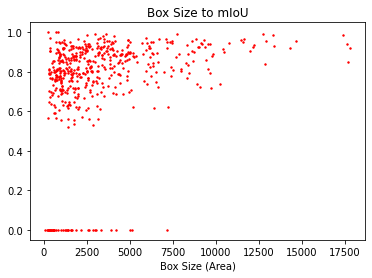

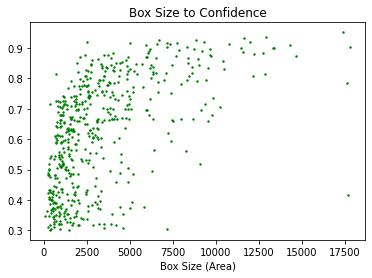

yolov5l6-int8-int-data 0.5256130948346834
TP conf 0.655317618
FP conf 0.41275049999999996


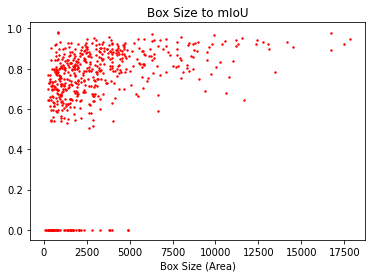

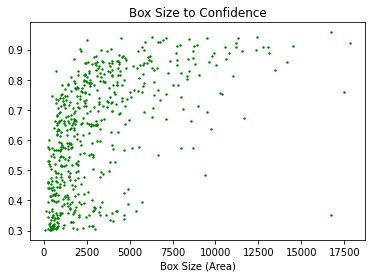

<Figure size 432x288 with 0 Axes>

In [28]:
evaluator = Evaluator()

model_miou_list = []
for model_name in model_names:
    allBoundingBoxes = BoundingBoxes()
    for mixed_image_name in mixed_image_names:
        boundingBoxes = BoundingBoxes()
        det = get_formatted_det_bboxes(model_name, mixed_image_name)
        boundingBoxes.concatBoundingBoxes(det)
        allBoundingBoxes.concatBoundingBoxes(det)
        gt = get_formatted_gt_bboxes(model_name, mixed_image_name)
        boundingBoxes.concatBoundingBoxes(gt)
        allBoundingBoxes.concatBoundingBoxes(gt)
        #print(model_name, mixed_image_name, evaluator.GetPascalVOCMetrics(boundingBoxes)[0]['AP'])
    r = evaluator.GetPascalVOCMetrics(allBoundingBoxes)[0]
    print(model_name, r['AP'])
    print('TP conf', r['TP conf'])
    print('FP conf', r['FP conf'])
    size_miou_conf = r['size miou conf']
    draw_size_miou_conf(size_miou_conf)

# Check Prediction bboxes

In [24]:
def draw_bbox(image, bboxes, linecolor=(255, 0, 0)):
    for b in bboxes:
        c1, c2 = (b[0], b[1]), (b[2], b[3])
        cv2.rectangle(image, c1, c2, linecolor, 2)
    return image

In [25]:
def visualize(model_name, mixed_image_name):
    iou_sum, num, TP, gt_len, pred_bboxes, fp_boxes = get_info(model_name, mixed_image_name)

    original_image = cv2.imread('../coco_mixed_yolov5/size50to150/val/images/'+mixed_image_name+'.png')
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    image = draw_bbox(original_image, pred_bboxes)
    image = draw_bbox(image, fp_boxes, (0, 255, 0))

    plt.figure(figsize=(12,12))
    plt.title(model_name+' '+mixed_image_name)
    plt.imshow(image)
    plt.show()
    
    print(model_name, mixed_image_name)
    print('pd_boxes',len(pred_bboxes))
    print('gt_boxes',gt_len)
    print('TP',TP)
    print('FP',len(fp_boxes))
    print('num',num)
    print('fp_boxes', fp_boxes)
    print('miou',iou_sum/num) 

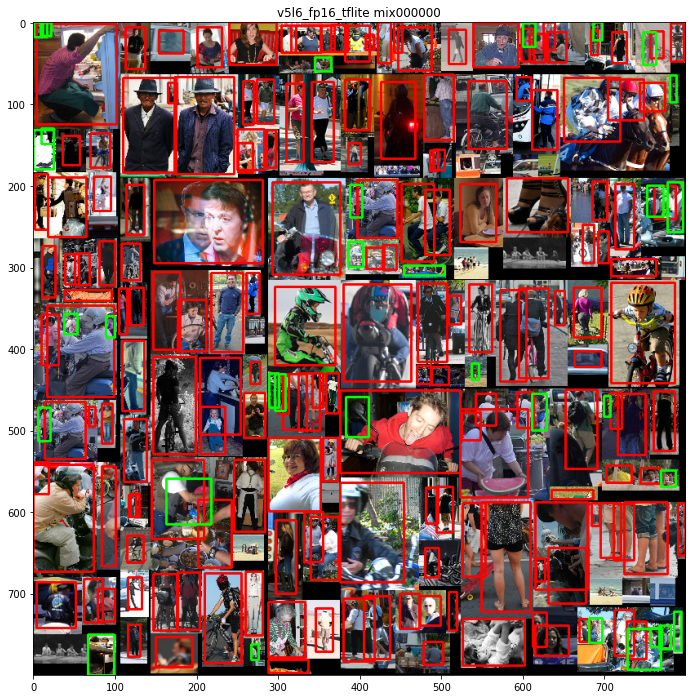

v5l6_fp16_tflite mix000000
pd_boxes 207
gt_boxes 203
TP 174
FP 33
num 236
fp_boxes [[785, 722, 794, 770, 0.316618], [600, 1, 615, 30, 0.322281], [1, 0, 9, 18, 0.324035], [296, 431, 309, 476, 0.324657], [686, 0, 697, 22, 0.327138], [12, 0, 22, 17, 0.341666], [777, 196, 796, 257, 0.361563], [756, 742, 770, 765, 0.361819], [454, 298, 504, 310, 0.368566], [9, 0, 17, 18, 0.373652], [345, 43, 365, 60, 0.382679], [10, 130, 25, 149, 0.393558], [163, 559, 218, 615, 0.414441], [780, 65, 788, 98, 0.435512], [769, 549, 787, 569, 0.448303], [537, 418, 546, 438, 0.450778], [752, 200, 772, 238, 0.451879], [767, 739, 781, 768, 0.501722], [89, 360, 100, 386, 0.523684], [38, 357, 54, 382, 0.536359], [681, 730, 697, 760, 0.543651], [289, 430, 301, 472, 0.55403], [728, 743, 769, 793, 0.566582], [699, 458, 707, 483, 0.602812], [611, 455, 629, 500, 0.61385], [388, 199, 403, 239, 0.65821], [386, 269, 404, 300, 0.661014], [267, 762, 276, 781, 0.667186], [6, 472, 21, 513, 0.688032], [747, 12, 763, 52, 0.709937

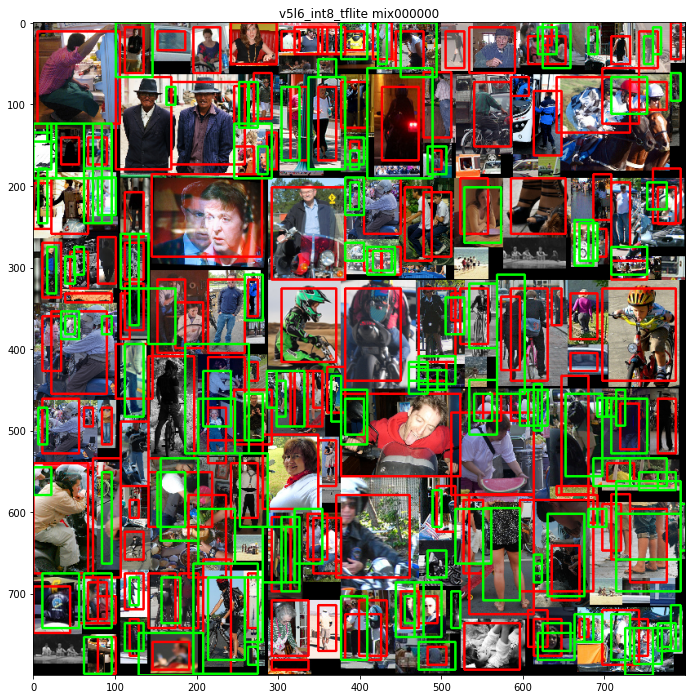

v5l6_int8_tflite mix000000
pd_boxes 294
gt_boxes 203
TP 155
FP 139
num 342
fp_boxes [[467, 686, 500, 753, 0.336592], [320, 596, 354, 663, 0.336592], [152, 551, 186, 618, 0.336592], [731, 534, 776, 568, 0.336592], [472, 409, 517, 443, 0.336592], [708, 275, 752, 309, 0.336592], [118, 259, 129, 326, 0.336592], [73, 179, 84, 246, 0.336592], [62, 179, 96, 246, 0.336592], [73, 124, 84, 191, 0.336592], [28, 124, 62, 191, 0.336592], [246, 124, 292, 191, 0.336592], [624, 0, 658, 56, 0.336592], [781, 714, 793, 770, 0.350617], [157, 680, 180, 736, 0.350617], [613, 663, 623, 686, 0.350617], [613, 652, 623, 675, 0.350617], [765, 551, 787, 573, 0.350617], [703, 460, 714, 483, 0.350617], [50, 275, 62, 309, 0.350617], [409, 275, 443, 309, 0.350617], [416, 280, 439, 304, 0.350617], [663, 242, 686, 298, 0.350617], [275, 152, 287, 186, 0.350617], [0, 124, 22, 146, 0.350617], [708, 67, 752, 112, 0.350617], [759, 6, 769, 39, 0.350617], [765, 736, 787, 770, 0.434765], [770, 742, 781, 765, 0.434765], [618, 7

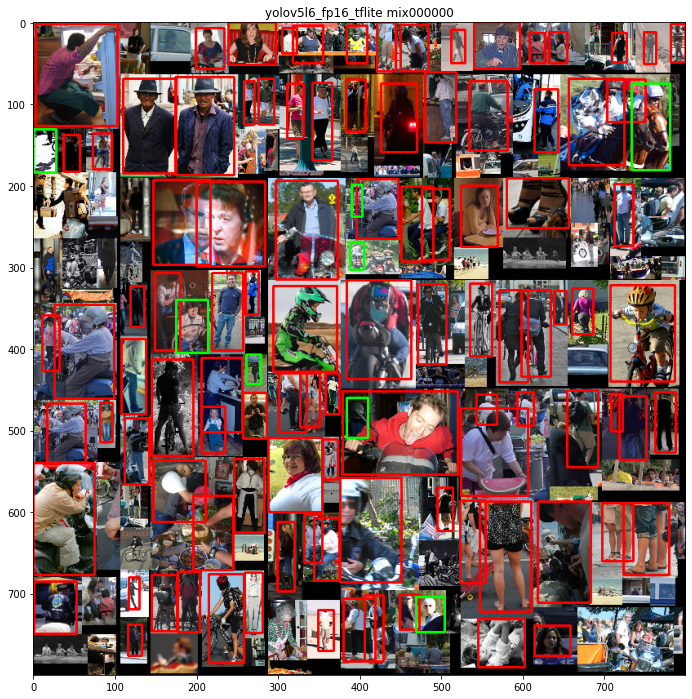

yolov5l6_fp16_tflite mix000000
pd_boxes 110
gt_boxes 203
TP 102
FP 8
num 211
fp_boxes [[384, 460, 410, 509, 0.326095], [390, 199, 403, 238, 0.374759], [261, 407, 279, 443, 0.390913], [733, 75, 780, 181, 0.391737], [0, 131, 28, 184, 0.485822], [388, 270, 405, 303, 0.533186], [469, 704, 504, 747, 0.631249], [175, 340, 214, 405, 0.744642]]
miou 0.3995134976016741


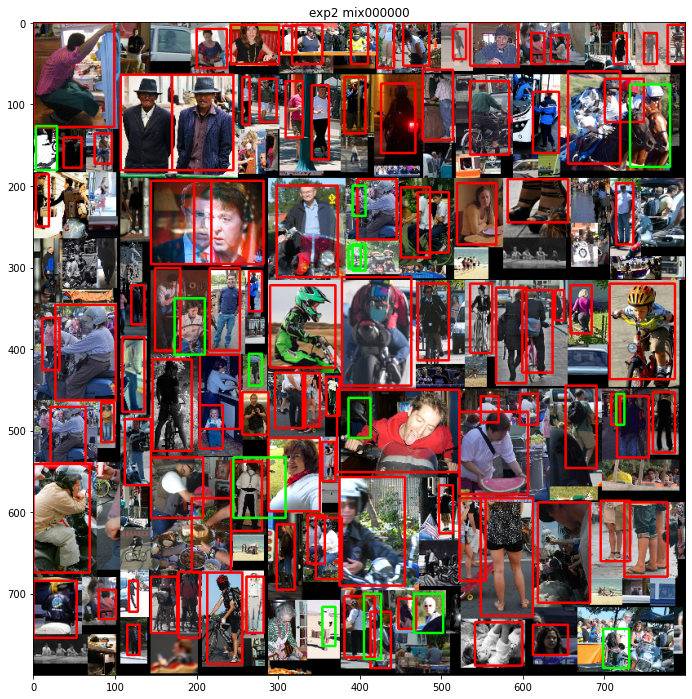

exp2 mix000000
pd_boxes 117
gt_boxes 203
TP 103
FP 14
num 217
fp_boxes [[698, 743, 730, 791, 0.323516], [386, 274, 401, 301, 0.337033], [245, 533, 309, 607, 0.393537], [391, 200, 407, 237, 0.393537], [386, 460, 413, 509, 0.395664], [731, 76, 780, 177, 0.44592], [264, 406, 280, 445, 0.446718], [714, 455, 724, 493, 0.498569], [3, 127, 29, 181, 0.561588], [391, 272, 407, 304, 0.593851], [405, 700, 426, 780, 0.62966], [354, 716, 370, 764, 0.638168], [466, 700, 502, 748, 0.71794], [173, 338, 210, 407, 0.767398]]
miou 0.37004969719492176


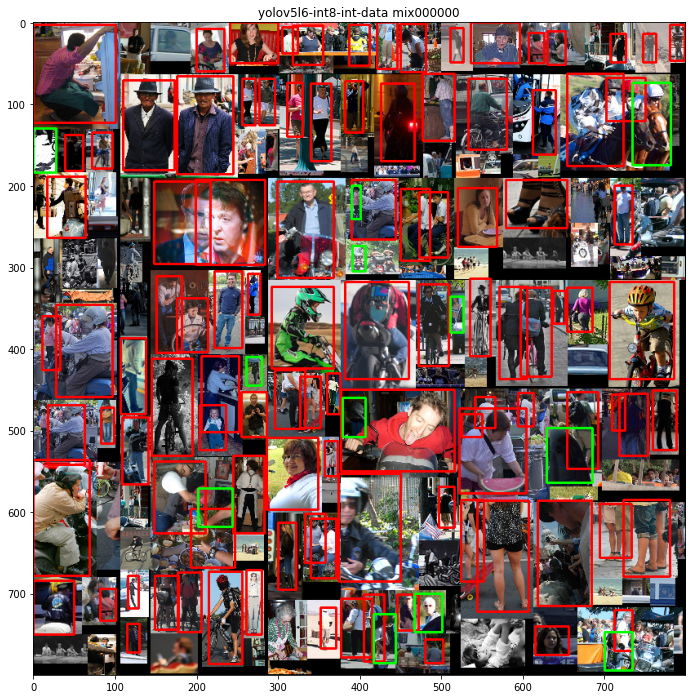

yolov5l6-int8-int-data mix000000
pd_boxes 118
gt_boxes 203
TP 106
FP 12
num 215
fp_boxes [[417, 725, 444, 785, 0.309071], [629, 497, 685, 564, 0.335472], [511, 336, 527, 380, 0.343413], [202, 571, 244, 618, 0.346193], [700, 747, 734, 794, 0.355153], [379, 460, 407, 508, 0.358088], [261, 410, 280, 445, 0.426184], [734, 74, 781, 175, 0.438295], [390, 200, 401, 241, 0.443795], [391, 274, 407, 305, 0.554064], [0, 130, 28, 184, 0.574764], [467, 700, 501, 747, 0.656609]]
miou 0.3835491616527125


In [96]:
selected_models = ['v5l6_fp16_tflite', 'v5l6_int8_tflite', 'yolov5l6_fp16_tflite', 'exp2', 'yolov5l6-int8-int-data']
mixed_image_name = 'mix000000'
for model_name in selected_models:
    visualize(model_name, mixed_image_name)

In [20]:
def get_gt_bboxes(mixed_image_name):
    size_key = 'size50to150'
    gt_log = './data/dataset/coco_mixed_val.txt'
    with open(gt_log, 'r') as f:
        gts = f.readlines()
    for i in range(len(gts)):
        line = gts[i]
        if size_key in line and mixed_image_name in line:
            gt_bboxes = line.rsplit()[1:]
            gt_bboxes = [[int(e) for e in gt_bbox.split(',')] for gt_bbox in gt_bboxes]
    return gt_bboxes

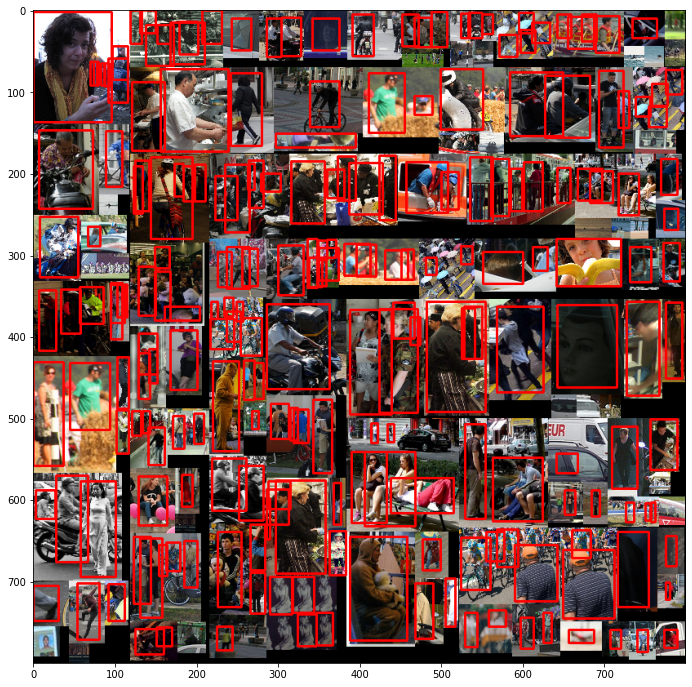

In [30]:
original_image = cv2.imread('./data/mixed_images/'+mixed_image_name+'.png')
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
gt_bboxes = get_gt_bboxes(mixed_image_name)
image = draw_bbox(original_image, gt_bboxes)
plt.figure(figsize=(12,12))
plt.imshow(image)